### Finetuning SAM with 3D neuron data

##### Setup notebook and import data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
# Install the required libraries
#SAM
!pip install git+https://github.com/facebookresearch/segment-anything.git
#Transformers
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install datasets

  Cloning https://github.com/facebookresearch/segment-anything.git to c:\users\harry\appdata\local\temp\pip-req-build-zybd5ke4
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 526fd066dea338ba2ca08886853bd37ffd6a8aec
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git 'C:\Users\harry\AppData\Local\Temp\pip-req-build-zybd5ke4'


In [46]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tifffile
import os
import random
from scipy import ndimage
from glob import glob
import cv2
import datasets
from PIL import Image
from torch.utils.data import Dataset
from transformers import SamProcessor, SamModel, SamConfig
from torch.optim import Adam
import monai
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [104]:
# Local file directories
image_dir = "images/fin/3Dimages"
label_dir = "images/fin/3Dlabels"

# Find file paths and sort
image_paths = sorted(glob(os.path.join(image_dir, "*")))
label_paths = sorted(glob(os.path.join(label_dir, "*")))

In [105]:
images = []
labels = []

for path in image_paths:
  image = tifffile.imread(path)

  # Flatten the 3D stack by adding each 2D slice to the flattened list
  for slice_idx in range(image.shape[0]):
    images.append(image[slice_idx])

for path in label_paths:
  label = tifffile.imread(path)

  # Flatten the 3D stack by adding each 2D slice to the flattened list
  for slice_idx in range(label.shape[0]):
    labels.append(label[slice_idx])

##### Preprocess data

In [106]:
# Resize slices of image and mask to target size
target_size = (256, 256)

resized_images = []
resized_masks = []

for image in images:
  resized_image = cv2.resize(image, target_size)
  resized_images.append(resized_image)

for mask in labels:
  resized_mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)
  resized_masks.append(resized_mask)

In [107]:
# Convert list to 3D numpy array
resized_images = np.array(resized_images)
resized_masks = np.array(resized_masks)

In [108]:
resized_images.shape

(4030, 256, 256)

In [109]:
# Normalise mask values 0,1
resized_masks = resized_masks / 255

In [110]:
np.unique(resized_masks)

array([0., 1.])

In [111]:
# Create a list to store the indices of non-empty masks
valid_indices = [i for i, mask in enumerate(resized_masks) if mask.max() != 0]

# Filter the image and mask arrays to keep only the non-empty masks and corresponding images
images = resized_images[valid_indices]
masks = resized_masks[valid_indices]

print("Image shape:", images.shape)
print("Mask shape:", masks.shape)

Image shape: (3510, 256, 256)
Mask shape: (3510, 256, 256)


In [112]:
# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in images],
    "label": [Image.fromarray(mask) for mask in masks],
}

# Create the dataset using the datasets.Dataset class
dataset = datasets.Dataset.from_dict(dataset_dict)

In [113]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 3510
})

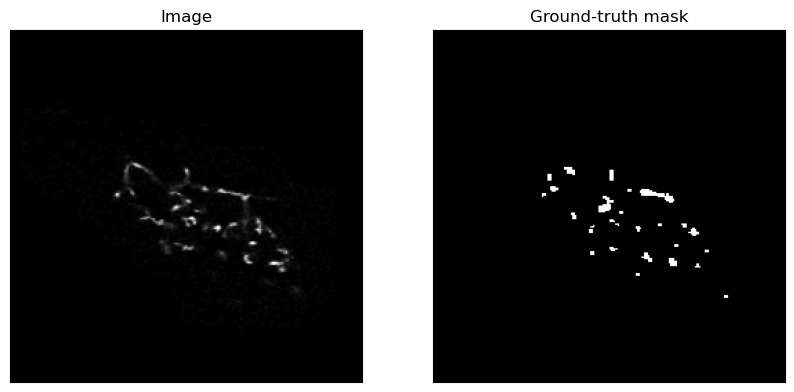

In [147]:
# Plot image and mask at random

img_num = random.randint(0, images.shape[0]-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the image
axes[0].imshow(np.array(example_image), cmap='gray')
axes[0].set_title("Image")

# Plot the mask
axes[1].imshow(np.array(example_mask), cmap='gray')
axes[1].set_title("Ground-truth mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

plt.show()

In [122]:
# Get bounding boxes from mask which are then overlayed onto image for prompt

def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)

  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

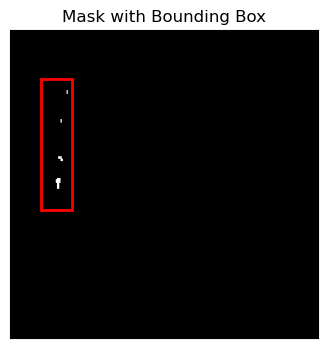

In [141]:
# Sample an item from the dataset
img_num = random.randint(0, masks.shape[0]-1)
item = dataset[img_num]

example_mask = dataset[img_num]["label"]
example_mask = np.array(example_mask)

# Get the bounding box from the mask
bbox = get_bounding_box(example_mask)

# Plot the image and mask with the bounding box
fig, ax = plt.subplots(figsize=(8, 4))

# Show the mask
ax.imshow(example_mask, cmap='gray')

# Create a rectangle patch for the bounding box
rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], linewidth=2, edgecolor='r', facecolor='none')

# Add the rectangle to the plot
ax.add_patch(rect)

# Set the title and hide axis ticks
ax.set_title("Mask with Bounding Box")
ax.set_xticks([])
ax.set_yticks([])

plt.show()

In [148]:
# Split into train and test sets
train_indices, test_indices = train_test_split(range(len(dataset)), test_size=0.1, random_state=42)

train_set = torch.utils.data.Subset(dataset, train_indices)
test_set = torch.utils.data.Subset(dataset, test_indices)

##### Setup dataset class

In [149]:
class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]

    # Convert to numpy array
    image = np.array(image)

    # Check if the image is greyscale and if so convert to RGB
    if image.ndim == 2:
        image = np.expand_dims(image, axis=-1)
        image = np.repeat(image, 3, axis=2)

    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [150]:
# Initialise processor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [151]:
# Create train and test instances of SAMDataset
train_dataset = SAMDataset(dataset=train_set, processor=processor)
test_dataset = SAMDataset(dataset=test_set, processor=processor)

In [152]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


In [153]:
# Create a DataLoader instance for the training and test sets
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=True)

In [154]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [155]:
batch = next(iter(test_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [156]:
# Metric functions

def iou_score(segmentation, gt):
    """A function to compute IoU"""
    intersection = (segmentation*gt).sum()
    union = segmentation.sum() + gt.sum() - intersection
    score = intersection / union
    return score

def dice_score(segmentation, gt):
    """A function to compute Dice coefficient"""
    intersection = (segmentation*gt).sum()
    score = (2. *intersection) / (segmentation.sum() + gt.sum())
    return score

##### Setup training

In [157]:
# Load the model
model = SamModel.from_pretrained("facebook/sam-vit-base")

# Ensure we only fine-tune the mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [158]:
# Initialise the optimiser and select hyperparameters
optimiser = Adam(model.mask_decoder.parameters(), lr=1e-4, weight_decay=0)

# Initalise DiceLoss function
seg_loss = monai.losses.DiceLoss(sigmoid=True)

In [159]:
# Define Early Stopping parameters
# early_stop_epoch = 5
# improvement = 0.01
# best_dice_score = -float('inf')
# epochs_without_improvement = 0

# Define number of epochs
num_epochs = 20

# Set model to cuda device
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

training_losses = []
test_losses_score = []
dice_scores_test = []
iou_scores_test = []

# Start training loop
for epoch in range(num_epochs):
  # Put model into train mode
  model.train()

  epoch_losses = []

  # Loop for each batch in training data
  for batch in tqdm(train_dataloader):
    # Forward pass for each batch input upscaled image and bounding box data into model to get output and place in device memory
    outputs = model(pixel_values=batch["pixel_values"].to(device),
                    input_boxes=batch["input_boxes"].to(device),
                    multimask_output=False)

    # Outputs logits of segmentation mask
    segmentation_logit = outputs.pred_masks.squeeze(1)

    # Load mask from batch and convert to same dtype and size as segmentation
    gt_mask = batch["ground_truth_mask"].unsqueeze(1).float().to(device)

    # Calculate loss (Diceloss)
    loss = seg_loss(segmentation_logit, gt_mask)

    # Backward pass
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

    # Append loss for batch to epoch loss list
    epoch_losses.append(loss.item())

  # Calculate mean loss for epoch
  training_losses.append(mean(epoch_losses))
  print(f"Epoch: {epoch+1}, Loss: {mean(epoch_losses)}")

  # Put model into eval mode
  model.eval()

  # Instantiate empty lists for metrics
  test_losses = []
  dice_scores = []
  iou_scores = []

  # Ensure no weights are altered
  with torch.no_grad():
    for batch in tqdm(test_dataloader):

      # Forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # Compute loss
      segmentation_logit = outputs.pred_masks.squeeze(1)
      gt_mask = batch["ground_truth_mask"].unsqueeze(1).float().to(device)

      loss = seg_loss(segmentation_logit, gt_mask)

      # Append loss for batch to epoch loss list
      test_losses.append(loss.item())

      # Convert logits with sigmoid function
      segmentation_prob = torch.sigmoid(segmentation_logit)

      # Convert probability map to binary
      predicted_mask_bin = ((segmentation_prob) > 0.5).float()

      # Compute Dice and IoU metrics
      dice = dice_score(predicted_mask_bin, gt_mask)
      iou = iou_score(predicted_mask_bin, gt_mask)

      # Append metrics to lists
      dice_scores.append(dice.item())
      iou_scores.append(iou.item())

    test_losses_score.append(mean(test_losses))
    iou_scores_test.append(mean(iou_scores))
    dice_scores_test.append(mean(dice_scores))

    print(f"Epoch: {epoch+1}, test loss: {mean(test_losses)}, test iou: {mean(iou_scores)}, test dice: {mean(dice_scores)}")

    # Implement early stopping
    # epoch_dice_score = mean(dice_scores)
    # if epoch_dice_score > best_dice_score + improvement:
    #   best_dice_score = epoch_dice_score
    #   epochs_without_improvement = 0
    # else:
    #   epochs_without_improvement += 1

    # if epochs_without_improvement >= early_stop_epoch:
    #   print(f"Early stopping at {epoch+1}")
    #   break

100%|██████████████████████████████████████████████████████████████████████████████| 1580/1580 [08:07<00:00,  3.24it/s]


Epoch: 1, Loss: 0.6176587640484678


100%|████████████████████████████████████████████████████████████████████████████████| 176/176 [00:52<00:00,  3.36it/s]


Epoch: 1, test loss: 0.6222892657599666, test iou: 0.25442480213347485, test dice: 0.3924210767515681


100%|██████████████████████████████████████████████████████████████████████████████| 1580/1580 [08:09<00:00,  3.23it/s]


Epoch: 2, Loss: 0.6048686771264559


100%|████████████████████████████████████████████████████████████████████████████████| 176/176 [00:52<00:00,  3.36it/s]


Epoch: 2, test loss: 0.6151032500307668, test iou: 0.26506810770793393, test dice: 0.40564324596727436


100%|██████████████████████████████████████████████████████████████████████████████| 1580/1580 [08:09<00:00,  3.23it/s]


Epoch: 3, Loss: 0.5938317379808125


100%|████████████████████████████████████████████████████████████████████████████████| 176/176 [00:52<00:00,  3.35it/s]


Epoch: 3, test loss: 0.6038508103652434, test iou: 0.281503653047945, test dice: 0.42636317802085116


100%|██████████████████████████████████████████████████████████████████████████████| 1580/1580 [08:08<00:00,  3.23it/s]


Epoch: 4, Loss: 0.5981458902359009


100%|████████████████████████████████████████████████████████████████████████████████| 176/176 [00:52<00:00,  3.35it/s]


Epoch: 4, test loss: 0.6087591306052424, test iou: 0.2634018170594407, test dice: 0.4042933434565467


100%|██████████████████████████████████████████████████████████████████████████████| 1580/1580 [08:09<00:00,  3.23it/s]


Epoch: 5, Loss: 0.5915715842118746


100%|████████████████████████████████████████████████████████████████████████████████| 176/176 [00:52<00:00,  3.35it/s]


Epoch: 5, test loss: 0.5952515720643781, test iou: 0.2840568179539828, test dice: 0.42835767050697043


100%|██████████████████████████████████████████████████████████████████████████████| 1580/1580 [08:09<00:00,  3.23it/s]


Epoch: 6, Loss: 0.5818046739207038


100%|████████████████████████████████████████████████████████████████████████████████| 176/176 [00:52<00:00,  3.35it/s]


Epoch: 6, test loss: 0.5939770207147707, test iou: 0.28194549873428926, test dice: 0.4250183787662536


100%|██████████████████████████████████████████████████████████████████████████████| 1580/1580 [08:09<00:00,  3.23it/s]


Epoch: 7, Loss: 0.5810128828392753


100%|████████████████████████████████████████████████████████████████████████████████| 176/176 [00:52<00:00,  3.35it/s]


Epoch: 7, test loss: 0.6041027351536534, test iou: 0.2717837442072447, test dice: 0.415095042839477


100%|██████████████████████████████████████████████████████████████████████████████| 1580/1580 [08:13<00:00,  3.20it/s]


Epoch: 8, Loss: 0.5765200985572007


100%|████████████████████████████████████████████████████████████████████████████████| 176/176 [00:52<00:00,  3.35it/s]


Epoch: 8, test loss: 0.57836274091493, test iou: 0.2885239874436097, test dice: 0.4346591112288562


100%|██████████████████████████████████████████████████████████████████████████████| 1580/1580 [08:28<00:00,  3.11it/s]


Epoch: 9, Loss: 0.5695840451724922


100%|████████████████████████████████████████████████████████████████████████████████| 176/176 [00:55<00:00,  3.20it/s]


Epoch: 9, test loss: 0.5866103107956323, test iou: 0.2960032434520227, test dice: 0.44368099431845953


100%|██████████████████████████████████████████████████████████████████████████████| 1580/1580 [08:31<00:00,  3.09it/s]


Epoch: 10, Loss: 0.5693925770023202


100%|████████████████████████████████████████████████████████████████████████████████| 176/176 [00:54<00:00,  3.20it/s]


Epoch: 10, test loss: 0.5813188979571516, test iou: 0.28379938629223034, test dice: 0.4278071182356639


100%|██████████████████████████████████████████████████████████████████████████████| 1580/1580 [08:30<00:00,  3.09it/s]


Epoch: 11, Loss: 0.5665930555025234


100%|████████████████████████████████████████████████████████████████████████████████| 176/176 [00:54<00:00,  3.20it/s]


Epoch: 11, test loss: 0.5961820161478086, test iou: 0.28238611822863197, test dice: 0.4263866864758628


100%|██████████████████████████████████████████████████████████████████████████████| 1580/1580 [08:30<00:00,  3.09it/s]


Epoch: 12, Loss: 0.5619764577550224


100%|████████████████████████████████████████████████████████████████████████████████| 176/176 [00:54<00:00,  3.20it/s]


Epoch: 12, test loss: 0.5779731654646721, test iou: 0.29054356848990376, test dice: 0.4375834024976939


100%|██████████████████████████████████████████████████████████████████████████████| 1580/1580 [08:30<00:00,  3.09it/s]


Epoch: 13, Loss: 0.5616814876847629


100%|████████████████████████████████████████████████████████████████████████████████| 176/176 [00:54<00:00,  3.21it/s]


Epoch: 13, test loss: 0.5705277491360903, test iou: 0.29821951122192497, test dice: 0.445526669870808


100%|██████████████████████████████████████████████████████████████████████████████| 1580/1580 [08:30<00:00,  3.10it/s]


Epoch: 14, Loss: 0.5573505913720855


100%|████████████████████████████████████████████████████████████████████████████████| 176/176 [00:54<00:00,  3.21it/s]


Epoch: 14, test loss: 0.5734203351153568, test iou: 0.29120194479103456, test dice: 0.4370242165909572


100%|██████████████████████████████████████████████████████████████████████████████| 1580/1580 [08:30<00:00,  3.10it/s]


Epoch: 15, Loss: 0.5518979373800603


100%|████████████████████████████████████████████████████████████████████████████████| 176/176 [00:54<00:00,  3.21it/s]


Epoch: 15, test loss: 0.573880281468684, test iou: 0.28921744031619956, test dice: 0.4328970832496204


100%|██████████████████████████████████████████████████████████████████████████████| 1580/1580 [08:30<00:00,  3.10it/s]


Epoch: 16, Loss: 0.5516623079022275


100%|████████████████████████████████████████████████████████████████████████████████| 176/176 [00:54<00:00,  3.21it/s]


Epoch: 16, test loss: 0.5614084701307795, test iou: 0.29640234644863417, test dice: 0.44249697181988845


100%|██████████████████████████████████████████████████████████████████████████████| 1580/1580 [08:30<00:00,  3.10it/s]


Epoch: 17, Loss: 0.5461071069859251


100%|████████████████████████████████████████████████████████████████████████████████| 176/176 [00:54<00:00,  3.20it/s]


Epoch: 17, test loss: 0.5708899313414638, test iou: 0.29659271451898594, test dice: 0.4433927202216265


100%|██████████████████████████████████████████████████████████████████████████████| 1580/1580 [08:30<00:00,  3.10it/s]


Epoch: 18, Loss: 0.5490212038725237


100%|████████████████████████████████████████████████████████████████████████████████| 176/176 [00:54<00:00,  3.20it/s]


Epoch: 18, test loss: 0.5743054617196321, test iou: 0.29088520584098826, test dice: 0.4358375182544643


100%|██████████████████████████████████████████████████████████████████████████████| 1580/1580 [08:30<00:00,  3.10it/s]


Epoch: 19, Loss: 0.5414935654099984


100%|████████████████████████████████████████████████████████████████████████████████| 176/176 [00:54<00:00,  3.21it/s]


Epoch: 19, test loss: 0.5671828522939574, test iou: 0.2944038158748299, test dice: 0.4420607195193456


100%|██████████████████████████████████████████████████████████████████████████████| 1580/1580 [08:30<00:00,  3.10it/s]


Epoch: 20, Loss: 0.5362492797306821


100%|████████████████████████████████████████████████████████████████████████████████| 176/176 [00:54<00:00,  3.21it/s]

Epoch: 20, test loss: 0.5704534263773398, test iou: 0.29742511752357875, test dice: 0.4427643106954003


##### Show metrics

In [278]:
output_dir = "output/3d_sam_metrics"

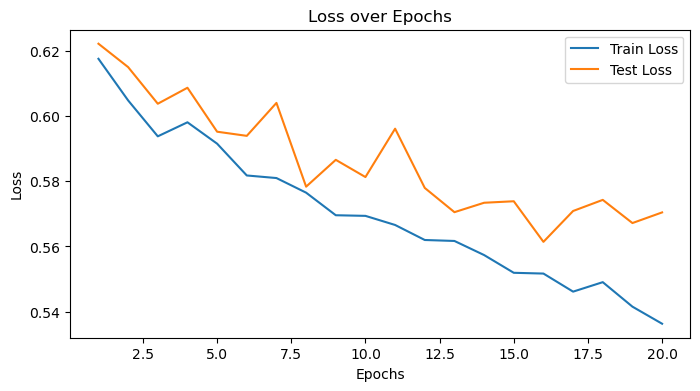

In [279]:
# Plot loss metrics

plt.figure(figsize=(8, 4))

epochs = range(1, num_epochs + 1)

plt.plot(epochs, training_losses, label='Train Loss')
plt.plot(epochs, test_losses_score, label='Test Loss')

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

plt.savefig(f"{output_dir}/3d_SAM_loss_results.png")
plt.show()

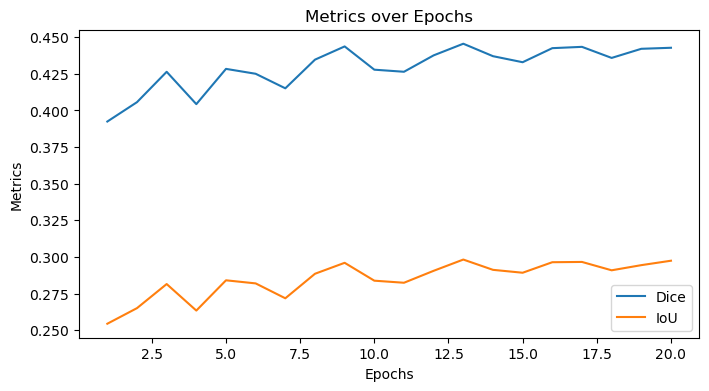

In [280]:
# Plot evaluation metrics

plt.figure(figsize=(8,4))

epochs = range(1, num_epochs + 1)

plt.plot(epochs, dice_scores_test, label="Dice")
plt.plot(epochs, iou_scores_test, label='IoU')

plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.title("Metrics over Epochs")
plt.legend()

plt.savefig(f"{output_dir}/3d_SAM_metrics_results.png")
plt.show()

In [161]:
# Save the model
torch.save(model.state_dict(), "models/3D_SAM.pth")

##### Inference

In [165]:
# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
my_model = SamModel(config=model_config)

# Update the model by loading the weights from saved file.
my_model.load_state_dict(torch.load("models/3D_SAM.pth"))

C:\Users\harry\AppData\Local\Temp\ipykernel_12432\847201362.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  my_model.load_state_dict(torch.load("models/3D_SAM.pth"))


<All keys matched successfully>

In [166]:
# set the model to device
device = "cuda" if torch.cuda.is_available() else "cpu"
my_model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

In [273]:
# Import image stack for inference
img_dir = 'images/fin/inf_set/3Dimages'
lab_dir = 'images/fin/inf_set/3Dlabels'

image_paths = sorted(glob(os.path.join(img_dir, "*.tif")))
label_paths = sorted(glob(os.path.join(lab_dir, "*.tif")))

In [274]:
inf_images = []
inf_masks = []

for image_path, label_path in zip(image_paths, label_paths):
    inf_image = tifffile.imread(image_path)
    inf_label = tifffile.imread(label_path)

    target_size = (256, 256)
    
    resized_image_stack = []
    resized_mask_stack = []

    for image in inf_image:
        resized_image = cv2.resize(image, target_size)
        resized_image_stack.append(resized_image)

    for mask in inf_label:
        resized_mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)
        resized_mask_stack.append(resized_mask)

    # Convert list to 3D numpy array
    resized_image_stack = np.array(resized_image_stack)
    resized_mask_stack = np.array(resized_mask_stack)

    # Normalize mask values 0,1
    resized_mask_stack = resized_mask_stack / 255

    # Filter out empty masks
    valid_indices = [i for i, mask in enumerate(resized_mask_stack) if mask.max() != 0]
    filtered_images = resized_image_stack[valid_indices]
    filtered_masks = resized_mask_stack[valid_indices]

    # Append the processed 3D stack to the list
    inf_images.append(filtered_images)
    inf_masks.append(filtered_masks)

print(f"Number of image stacks loaded: {len(inf_images)}")
print(f"Shape of first image stack: {inf_images[0].shape}")


Number of image stacks loaded: 4
Shape of first image stack: (93, 256, 256)


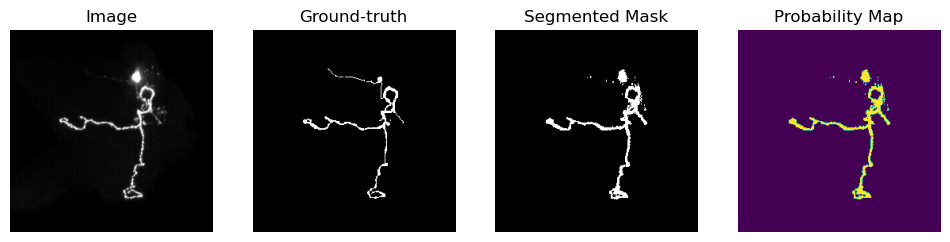

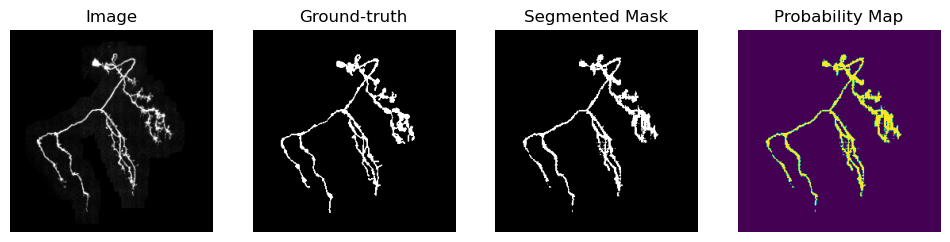

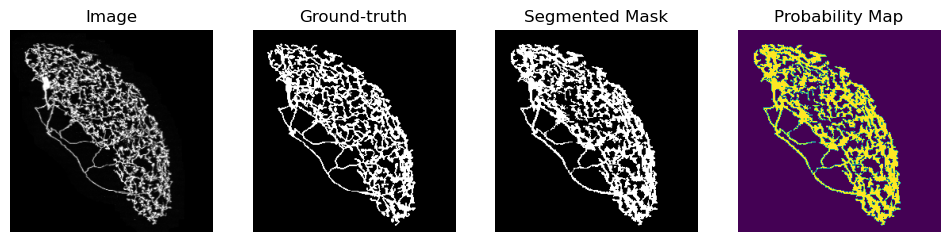

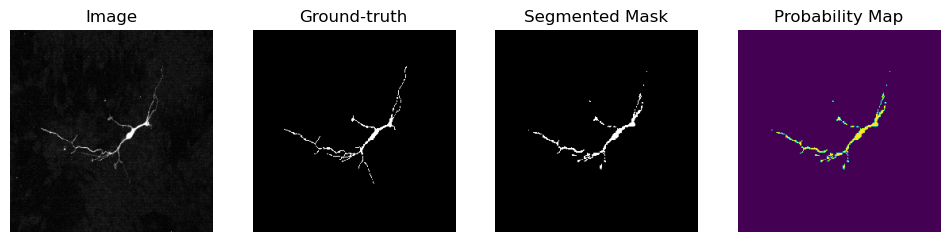

In [277]:
output_dir_3d = "output/3d_sam_stacks_tiff"
output_dir_fig = "output/3d_sam_inf"

for idx, (image_stack, mask_stack) in enumerate(zip(inf_images, inf_masks)):
    # Run inference on the selected stack slice by slice
    segmented_slices = []
    probability_slices = []

    for i in range(image_stack.shape[0]):
        # Get i-th slice from the selected 3D stack
        test_image = np.array(image_stack[i])

        # Convert to RGB if greyscale
        if test_image.ndim == 2:
            test_image = np.expand_dims(test_image, axis=-1)
            test_image = np.repeat(test_image, 3, axis=2)

        # Get box prompt from mask
        ground_truth_mask = np.array(mask_stack[i])
        prompt = get_bounding_box(ground_truth_mask)

        # Prepare image + box prompt for the model
        inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

        # Move the input tensor to the GPU
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Put into inference mode
        my_model.eval()

        # Forward pass with no changing of weights etc.
        with torch.no_grad():
            outputs = my_model(**inputs, multimask_output=False)

        # Apply sigmoid
        segmentation_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
        # Convert soft mask to hard mask
        segmentation_prob = segmentation_prob.cpu().numpy().squeeze()
        bin_segmentation = (segmentation_prob > 0.5).astype(np.uint8)

        probability_slices.append(segmentation_prob)
        segmented_slices.append(bin_segmentation)

    # Stack all slices into 3D volumes
    probability_volume = np.stack(probability_slices, axis=0)
    segmented_volume = np.stack(segmented_slices, axis=0)

    # Save segmented volume stack
    # segmented_volume = segmented_volume.astype(np.uint8)
    # tifffile.imwrite(f"{output_dir_3d}/segmented_volume_{idx}.tif", segmented_volume, imagej=True) 

    # Create MIPs for 2D plotting
    image_mip = np.max(image_stack, axis=0)
    gt_mip = np.max(mask_stack, axis=0)
    segmented_mip = np.max(segmented_volume, axis=0)
    probability_mip = np.max(probability_volume, axis=0)

    # Plot the images
    fig, axes = plt.subplots(1, 4, figsize=(12, 5))

    # Plot the image
    axes[0].imshow(np.array(image_mip), cmap='gray')
    axes[0].set_title("Image")
    axes[0].axis("off")

    # Plot the ground-truth mask
    axes[1].imshow(gt_mip, cmap='gray')
    axes[1].set_title("Ground-truth")
    axes[1].axis("off")

    # Plot the segmented mask
    axes[2].imshow(segmented_mip, cmap='gray')
    axes[2].set_title("Segmented Mask")
    axes[2].axis("off")

    # Plot the probability map
    im = axes[3].imshow(probability_mip, cmap='viridis', vmin=0, vmax=1)
    axes[3].set_title("Probability Map")
    axes[3].axis("off")

    plt.savefig(f"{output_dir_fig}/inference_results_stack{idx}.png", bbox_inches='tight', pad_inches=1)
    plt.show()

In [238]:
# Import image stack for inference
img_path = 'images/fin/inf_set/3Dimages/3d_image_02_mushroom_body_ab_cell_neuron.v3dpbd-1.tif'
lab_path = 'images/fin/inf_set/3Dlabels/3d_gt_02_mushroom_body_ab_cell_neuron.v3dpbd-1.tif'

inf_image = tifffile.imread(img_path)
inf_label = tifffile.imread(lab_path)

In [239]:
# Resize slices of image and mask to target size of training
target_size = (256, 256)

inf_images = []
inf_masks = []

for image in inf_image:
  inf_image = cv2.resize(image, target_size)
  inf_images.append(inf_image)

for mask in inf_label:
  inf_mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)
  inf_masks.append(inf_mask)

In [240]:
# Convert list to 3D numpy array
inf_images = np.array(inf_images)
inf_masks = np.array(inf_masks)

In [241]:
inf_images.shape

(101, 256, 256)

In [242]:
# Normalise mask values 0,1
inf_masks = inf_masks / 255

In [243]:
# Create a list to store the indices of non-empty masks
valid_indices = [i for i, mask in enumerate(inf_masks) if mask.max() != 0]

# Filter the image and mask arrays to keep only the non-empty masks and corresponding images
inf_images = inf_images[valid_indices]
inf_masks = inf_masks[valid_indices]

print("Image shape:", inf_images.shape)
print("Mask shape:", inf_masks.shape)

Image shape: (93, 256, 256)
Mask shape: (93, 256, 256)


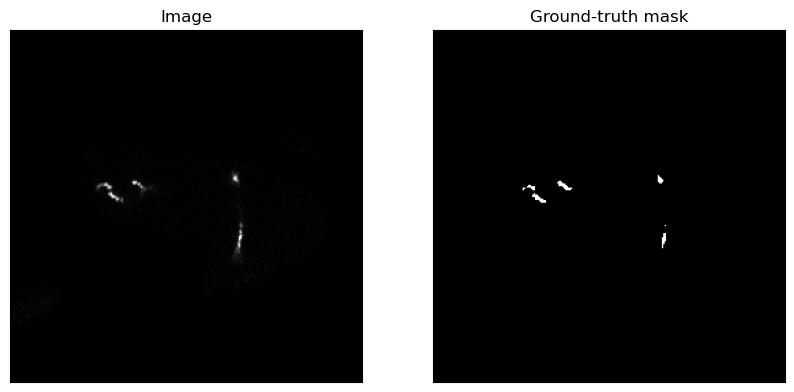

In [254]:
# Plot image and mask at random

img_num = random.randint(0, inf_images.shape[0]-1)
example_image = inf_images[img_num]
example_mask = inf_masks[img_num]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the image
axes[0].imshow(np.array(example_image), cmap='gray')
axes[0].set_title("Image")

# Plot the mask
axes[1].imshow(np.array(example_mask), cmap='gray')
axes[1].set_title("Ground-truth mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

plt.show()

In [260]:
# Run inference of 3D stack slice by slice

segmented_slices = []
probability_slices = []

for i in range(inf_images.shape[0]):
    # Get i-th slice from 3D stack
    test_image = np.array(inf_images[i])

    # Convert to RGB if greyscale
    if test_image.ndim == 2:
        test_image = np.expand_dims(test_image, axis=-1)
        test_image = np.repeat(test_image, 3, axis=2)

    # get box prompt from mask
    ground_truth_mask = np.array(inf_masks[i])
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image + box prompt for the model
    inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

    # Move the input tensor to the GPU
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Put into inference mode
    my_model.eval()

    # forward pass with no changing of weights etc.
    with torch.no_grad():
        outputs = my_model(**inputs, multimask_output=False)

    # apply sigmoid
    segmentation_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
    # convert soft mask to hard mask
    segmentation_prob = segmentation_prob.cpu().numpy().squeeze()
    bin_segmentation = (segmentation_prob > 0.5).astype(np.uint8)

    probability_slices.append(segmentation_prob)
    segmented_slices.append(bin_segmentation)


probability_volume = np.stack(probability_slices, axis=0)
segmented_volume = np.stack(segmented_slices, axis=0)

In [261]:
# Create mips for 2D plotting
image_mip = np.max(inf_images, axis=0)
gt_mip = np.max(inf_masks, axis=0)
segmented_mip = np.max(segmented_volume, axis=0)
probability_mip = np.max(probability_volume, axis=0)

Text(0.5, 1.0, 'Probability Map')

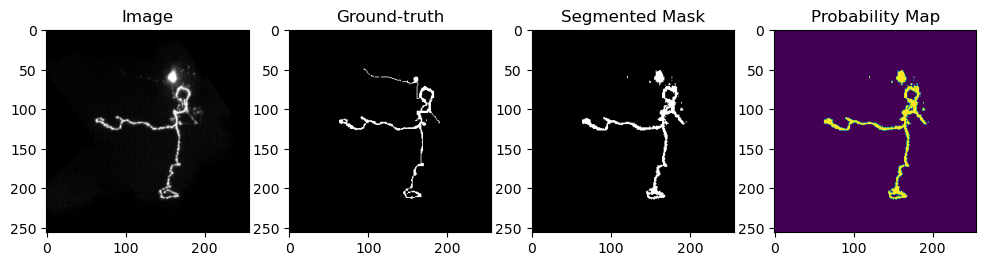

In [262]:
# Plot the images
fig, axes = plt.subplots(1, 4, figsize=(12, 5))

# Plot the image
axes[0].imshow(np.array(image_mip), cmap='gray')
axes[0].set_title("Image")

# Plot the segmented mask
axes[1].imshow(gt_mip, cmap='gray')
axes[1].set_title("Ground-truth")

# Plot the probability map
axes[2].imshow(segmented_mip, cmap='gray')
axes[2].set_title("Segmented Mask")

axes[3].imshow(probability_mip)
axes[3].set_title("Probability Map")

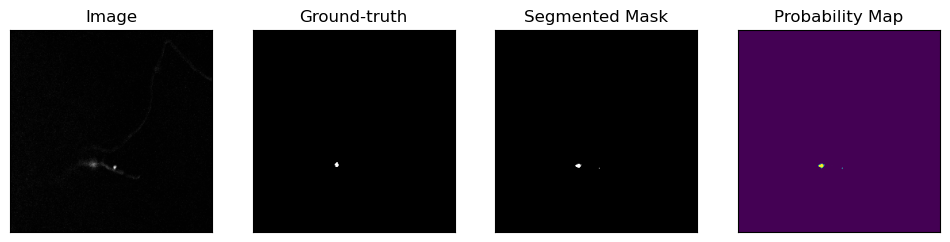

In [259]:
# take a random training example
idx = random.randint(0, images.shape[0]-1)

# test on non-random test data ([1] or [5])
# idx = 5

# load image and mask
test_image = np.array(dataset[idx]["image"])
test_mask = np.array(dataset[idx]["label"])

# test_image = inf_image
# test_mask = inf_label

# Convert to RGB if greyscale
if test_image.ndim == 2:
    test_image = np.expand_dims(test_image, axis=-1)
    test_image = np.repeat(test_image, 3, axis=2)

# get box prompt from mask
ground_truth_mask = np.array(dataset[idx]["label"])
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

# Put into inference mode
my_model.eval()

# forward pass with no changing of weights etc.
with torch.no_grad():
    outputs = my_model(**inputs, multimask_output=False)

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

# Plot the images
fig, axes = plt.subplots(1, 4, figsize=(12, 5))

# Plot the image
axes[0].imshow(np.array(test_image), cmap='gray')
axes[0].set_title("Image")

# Plot the segmented mask
axes[1].imshow(test_mask, cmap='gray')
axes[1].set_title("Ground-truth")

# Plot the probability map
axes[2].imshow(medsam_seg, cmap='gray')
axes[2].set_title("Segmented Mask")

axes[3].imshow(medsam_seg_prob)
axes[3].set_title("Probability Map")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

plt.show()